<a href="https://colab.research.google.com/github/NahinAlam001/CSE-465/blob/master/PCOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

print(torch.__version__)

2.2.1+cu121


In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [ ]:
from math import e
from pathlib import Path

data_path = Path('data/')
image_path = data_path/'images'

if image_path.is_dir():
  print(f'{image_path} does not exist... Skipping Folder Creation')
else:
  print(f'{image_path} does exist... Creating Folder')
  image_path.mkdir(parents=True, exist_ok=True)

data/images does exist... Creating Folder


In [ ]:
import gdown

gdown.download('https://drive.google.com/uc?export=download&id=10tPq2ERw3NHQWLsia3hnBb1Yc54dJwS8', 'images.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=10tPq2ERw3NHQWLsia3hnBb1Yc54dJwS8
From (redirected): https://drive.google.com/uc?export=download&id=10tPq2ERw3NHQWLsia3hnBb1Yc54dJwS8&confirm=t&uuid=599f4a72-ee0e-4263-abf2-e5db8268db39
To: /content/images.zip
100%|██████████| 132M/132M [00:01<00:00, 77.3MB/s]


'images.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('images.zip', 'r') as zip_ref:
  zip_ref.extractall()

print(f'Extracted files')

Extracted files


In [ ]:
# Define the destination directory
source_dirs = ['/content/data/test','/content/data/train']
destination_dir = '/content/data/images'

for directory in source_dirs:
  !mv {directory} {destination_dir}/

In [ ]:
import os

def walk_through_dir(dir_path):
  '''Walks through directories and prints the number of pictures in them'''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} pictures in {dirpath}')

walk_through_dir(image_path)

There are 2 directories and 0 pictures in data/images
There are 2 directories and 0 pictures in data/images/test
There are 0 directories and 787 pictures in data/images/test/infected
There are 0 directories and 1145 pictures in data/images/test/notinfected
There are 2 directories and 0 pictures in data/images/train
There are 0 directories and 781 pictures in data/images/train/infected
There are 0 directories and 1143 pictures in data/images/train/notinfected


In [ ]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
len(image_path_list)

3846

Class: infected | Size: (280, 259)


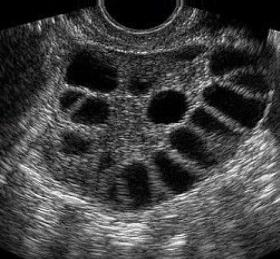

In [ ]:
import random
from PIL import Image

random.seed(42)

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f'Class: {image_class} | Size: {img.size}')
img

(-0.5, 279.5, 258.5, -0.5)

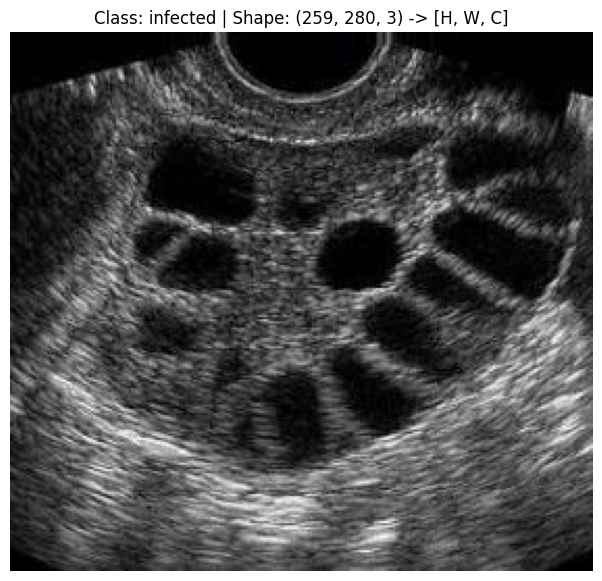

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

image_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f'Class: {image_class} | Shape: {image_as_array.shape} -> [H, W, C]')
plt.axis(False)

In [ ]:
from torchvision import transforms

data_transform = transforms.Compose([
  transforms.Resize(size=(64,64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

In [ ]:
data_transform(img).dtype

torch.float32

In [ ]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n = 3,
                            seed = None):
  '''
    Selects random images from a path of images and loads/transforms them. Plots the orginal vs the transformed version
  '''
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k= n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class:{image_path.parent.stem}', fontsize=16)

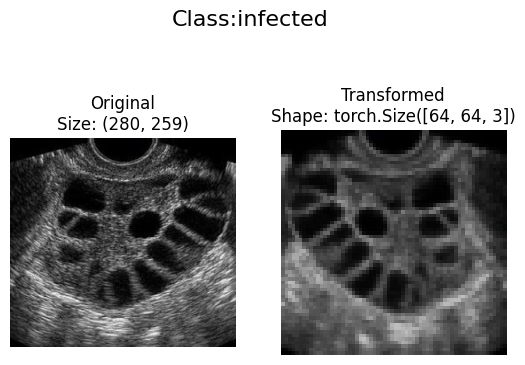

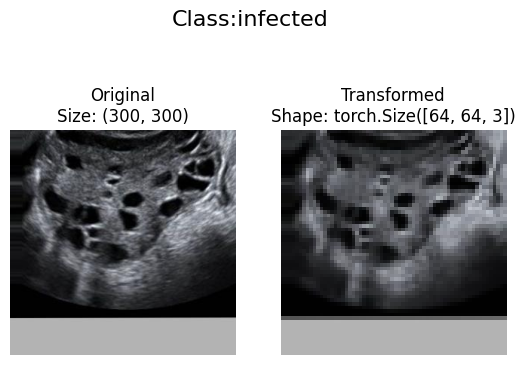

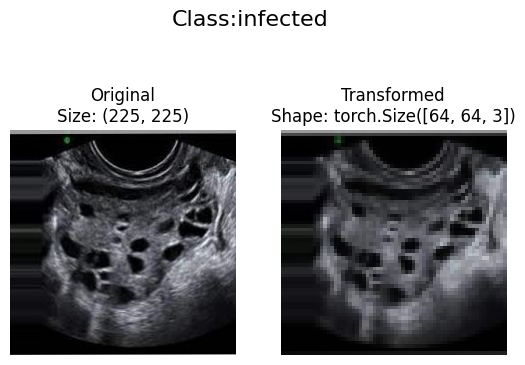

In [ ]:
plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n = 3,
                        seed = 42)

In [ ]:
train_dir = image_path/'train'
test_dir = image_path/'test'

train_dir, test_dir

(PosixPath('data/images/train'), PosixPath('data/images/test'))

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1924
     Root location: data/images/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1932
     Root location: data/images/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
class_names = train_data.classes
print(class_names)

['infected', 'notinfected']


In [ ]:
class_dict = train_data.class_to_idx
print(class_dict)

{'infected': 0, 'notinfected': 1}


In [ ]:
len(train_data), len(test_data)

(1924, 1932)

In [ ]:
train_data.samples[0]

('data/images/train/infected/img1.jpg', 0)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image Tensor: {img}\nImage Shape: {img.shape} | Image dtype: {img.dtype}\nImage Label: {label} | Label dtype: {type(label)}')

Image Tensor: tensor([[[0.4078, 0.4078, 0.4078,  ..., 0.4078, 0.4078, 0.4078],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1765, 0.1765, 0.1765,  ..., 0.1765, 0.1765, 0.1765],
         ...,
         [0.1373, 0.1373, 0.1373,  ..., 0.1373, 0.1373, 0.1373],
         [0.1373, 0.1373, 0.1373,  ..., 0.1373, 0.1373, 0.1373],
         [0.2392, 0.2392, 0.2392,  ..., 0.2392, 0.2392, 0.2392]],

        [[0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         ...,
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         [0.2314, 0.2314, 0.2314,  ..., 0.2314, 0.2314, 0.2314]],

        [[0.4039, 0.4039, 0.4039,  ..., 0.4039, 0.4039, 0.4039],
         [0.1608, 0.1608, 0.1608,  ..., 0.1608, 0.1608, 0.1608],
         [0.1608, 0.1608, 0.1608,  ..., 0.16

Orginal Shape: torch.Size([3, 64, 64]) -> [C, H, W]
Image Permuted: torch.Size([64, 64, 3]) -> [H, W, C]


(-0.5, 63.5, 63.5, -0.5)

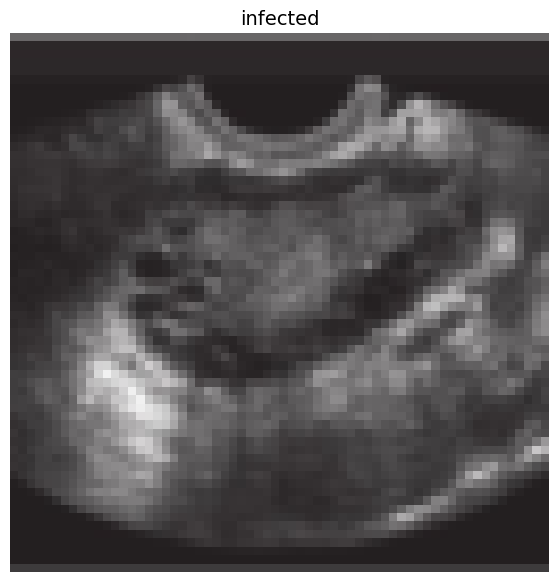

In [ ]:
img_permute = img.permute(1, 2, 0)

print(f'Orginal Shape: {img.shape} -> [C, H, W]\nImage Permuted: {img_permute.shape} -> [H, W, C]')

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)M
plt.title(class_names[label], fontsize=14)
plt.axis(False)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_data,
                        batch_size = BATCH_SIZE,
                        num_workers=os.cpu_count(),
                        shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = os.cpu_count(),
                             shuffle = False)


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ec063f57e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7ec063f570a0>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(1924, 1932)

In [ ]:
img, label = next(iter(train_dataloader))

print(f'Image Shape: {img.shape} -> [B, C, H, W]\nLabel Shape: {label.shape}')